## [1주차] 기본과제 - MNIST를 분류 모델로 학습하기

과제 목표:  MNIST를 regression model이 아닌 classification model로 구현합니다. 그리고 train과 test data에 대한 모델의 정확도를 plot하여 generalization error를 살펴봅니다.

### 1. 필요한 라이브러리 import

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

### 2. MNIST Dataset 로딩
- torchvision의 `MNIST` 클래스를 사용해 학습/테스트 데이터를 불러옵니다.
- 이미지 데이터는 tensor 형태로 변환합니다. (PyTorch 모델은 tensor만 이해할 수 있기 때문)

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

### 3. 데이터 확인
- 전체 학습 데이터 수, 첫 번째 이미지의 shape 및 레이블을 확인합니다.
- 시각화를 통해 첫 번째 이미지가 어떤 숫자인지 확인합니다.

60000
torch.Size([1, 28, 28]) 5


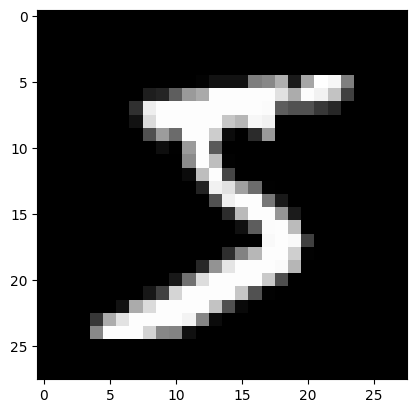

In [3]:
from matplotlib import pyplot as plt

print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

### 4. DataLoader 생성
- 학습과 테스트 데이터를 batch 단위로 불러올 수 있도록 DataLoader를 구성합니다.
- `shuffle=True`는 학습 데이터 섞기용입니다.
- Test data는 랜덤하게 섞일 필요가 없기 때문에 `shuffle=False`로 설정

In [4]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

### 5. 첫 번째 batch 확인
- DataLoader가 batch 단위로 데이터를 어떻게 제공하는지 shape을 통해 확인해봅니다.

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


### 6. MLP 모델 정의
- 3개의 선형 계층(`Linear`)과 `ReLU` 활성화 함수를 사용하여 다층 퍼셉트론(MLP) 분류 모델을 구성합니다.
- 최종 출력 차원은 **10**으로 설정되어 있으며, 이는 **MNIST가 0부터 9까지 총 10개의 클래스를 가지기 때문입니다.**
- 마지막 출력층(`layer3`) 뒤에는 `ReLU`나 `Softmax` 같은 **활성화 함수(activation)를 사용하지 않습니다.**
    - 그 이유는 `CrossEntropyLoss`가 내부적으로 `LogSoftmax`를 포함하고 있어,
      **모델의 출력은 소프트맥스가 적용되지 않은 "로짓(logits)" 상태여야 하기 때문입니다.**
    - ReLU는 음수를 0으로 만들어버리기 때문에, **softmax가 올바른 확률 분포를 계산하지 못할 수 있습니다.**

In [6]:
from torch import nn


class Model(nn.Module):
    def __init__(self, input_dim, n_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)  # CrossEntropy용: 10개의 클래스 출력
        self.act = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.layer3(x)  # 마지막에 softmax 안 씀! CrossEntropyLoss가 내부에서 처리함
        return x


model = Model(28 * 28 * 1, 1024)

### 7. 손실 함수 및 Optimizer 설정
- `CrossEntropyLoss`를 손실 함수로 사용하고, `SGD(Stochastic Gradient Descent)`를 기반으로 optimizer를 구현합니다.

In [7]:
from torch.optim import SGD

model = model.to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.001)

### 8. 정확도 측정 함수 정의
- 주어진 dataloader에 대해 model의 정확도를 측정하는 코드를 정의합니다.

In [8]:
def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    model.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)

            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()
    model.train()
    return acc / cnt

### 9. 모델 학습
- 매 epoch가 끝난 뒤, 모델의 trainloader와 testloader에 대한 정확도를 각각 리스트에 저장합니다.
- 훈련 중 측정된 trainloader와 testloader에 대한 정확도는 추후 시각화를 위해 사용됩니다.

In [9]:
n_epochs = 100
train_accs = []
test_accs = []

for epoch in range(n_epochs):
    total_loss = 0.

    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_acc = accuracy(model, trainloader)
    test_acc = accuracy(model, testloader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch:3d} | Loss: {total_loss} | Train Acc: {train_acc} | Test Acc: {test_acc}")

Epoch   0 | Loss: 539.2643678188324 | Train Acc: 0.19451666666666667 | Test Acc: 0.1927
Epoch   1 | Loss: 535.494190454483 | Train Acc: 0.30916666666666665 | Test Acc: 0.3059
Epoch   2 | Loss: 531.6052701473236 | Train Acc: 0.41301666666666664 | Test Acc: 0.414
Epoch   3 | Loss: 527.4581410884857 | Train Acc: 0.4922666666666667 | Test Acc: 0.4958
Epoch   4 | Loss: 522.9468715190887 | Train Acc: 0.55005 | Test Acc: 0.5547
Epoch   5 | Loss: 517.9231629371643 | Train Acc: 0.5932833333333334 | Test Acc: 0.5981
Epoch   6 | Loss: 512.2646968364716 | Train Acc: 0.6248833333333333 | Test Acc: 0.6287
Epoch   7 | Loss: 505.8041567802429 | Train Acc: 0.6477333333333334 | Test Acc: 0.6507
Epoch   8 | Loss: 498.39490151405334 | Train Acc: 0.6671166666666667 | Test Acc: 0.6681
Epoch   9 | Loss: 489.90041303634644 | Train Acc: 0.6836333333333333 | Test Acc: 0.6841
Epoch  10 | Loss: 480.1197612285614 | Train Acc: 0.69825 | Test Acc: 0.6971
Epoch  11 | Loss: 468.95275032520294 | Train Acc: 0.7107 | Tes

### 10. 정확도 시각화
- 학습 및 테스트 데이터셋에 대한 정확도를 epoch 단위로 시각화합니다.

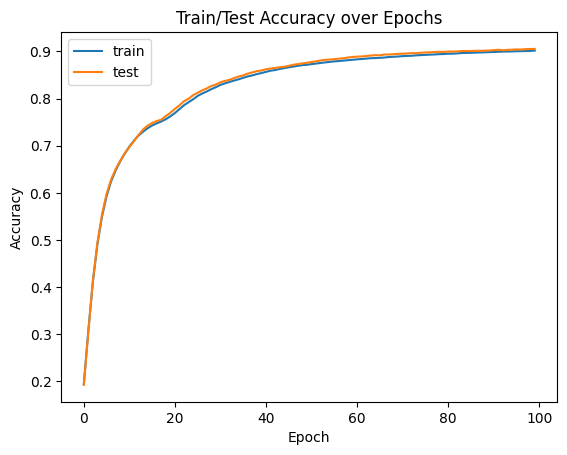

In [10]:
import numpy as np


def plot_acc(train_accs, test_accs, label1='train', label2='test'):
    x = np.arange(len(train_accs))
    plt.plot(x, train_accs, label=label1)
    plt.plot(x, test_accs, label=label2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Train/Test Accuracy over Epochs')
    plt.show()


plot_acc(train_accs, test_accs)